## Balistic Annihilation Simulation

In [88]:
import numpy as np
from matplotlib import pyplot as plt
import time
import sys
from tqdm import trange
#import seaborn as sns

def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

def BA_ini(p0, q, v, N, r=1):
    #  Constructs an initial configuration z for BA
    #  q = ratio between left and right arrows 
    #  Density of speed 0 = p0, v = (1-q)(1-p0), -1 = q(1-p0)
    #  Z[0,i] is the location of particle i
    #  Z[1,i] is the speed of particle i
    #  Z[2,i] is the indicator of particle being alive (for blockades in the stacked model, interpret it as the size of the alive B-stack)
    #  Particle of index N is conditioned to be a blockade
    #  r: success probability of geometric distribution for the number of blockades in a blockade stack 
    #  1 blockade per b-stack <-- r = 1

    # Poisson Point Process of N points
    E = np.random.exponential(1, 2 * N)  # initial gaps between particles
    x = np.array([])
    for i in np.arange(2 * N + 1):
        x = np.hstack((x, sum(E[0:i])))

    # sample speed configuration
    s = np.random.choice(3, 2 * N + 1, p=[(1 - q) * (1 - p0), p0, q * (1 - p0)])
    s = s - 1
    s[s == -1] = -v
    s[N] = 0  # condition on the middle particle of index N to have speed 0

    # construct initial configuration
    z = np.vstack((x, s, np.ones((1, 2 * N + 1))))
    
    # blow up each single blockade as a vertical stack of size Geom(r)
    for i in np.arange(2 * N + 1):
        if z[1, i] == 0: # ith particle is a blockade stack 
            z[2, i] = np.random.geometric(p=r, size=1)[0]
            #z[2, i] = 100
    return z


def BA_transition(eps, z):
    #  Ballistic annihilation transition map for esp amount of time
    #  input Z is 3 by N array
    #  z[0,i] is the location of particle i
    #  z[1,i] is the speed of particle i
    #  z[2,i] is the indicator of particle being alive
    #  two particles annihilate if they are within distance eps
    z_new = z.copy()
    z_new[0,:] = z[0,:] + z[1,:]*eps
    #print('z_new', z_new)

    #  delete two live particles within distance 2*eps
    #  this could be improved by sorting and considering nearest particles
    I = indices(z[2,:], lambda x: x >= 1)
    #print('# particles', len(I))
    for i in I:
        for j in I:
            if np.absolute(z_new[0, i] - z_new[0, j]) < 2*eps and i<j:
                #  np.delete(z_new,i,1) # delete ith column of z_new
                z_new[2, i] = np.maximum(0, int(z_new[2, i] -1))
                z_new[2, j] = np.maximum(0, int(z_new[2, j] -1))
               
    return z_new



def BA_trj(p0, q, v, r, N, time, eps):
    #  Ballistic annihilation with speeds -v,0,1
    #  Density of speed 0 = p0, v = (1-q)(1-p0), -1 = q(1-p0)
    #  2*N+1 = number of initial particles
    #  eps = duration of one iteration

    # build BA trajectory
    z = BA_ini(p0, q, v, N, r)
    trj = z
    for k in trange(time):
        z = BA_transition(eps, z)
        trj = np.dstack((trj, z))
    return trj


def BA_plot(p0=1/4, q=1/2, v=1, r = 1, N=200, time=100, eps=0.1, figsize_x=15):
    trj = BA_trj(p0, q, v, r, N, time, eps)
    fig = plt.figure(figsize = [figsize_x, figsize_x*time*eps/(2*N+1)])
    ax = fig.add_subplot(1, 1, 1)
    
    

    x1 = trj[0, :, :]  # x1(i,j) = location of particle i at iteration j
    y1 = np.arange(time+1)
    for i in np.arange(2*N):
        y1 = np.vstack((y1, np.arange(time + 1)))
    s1 = trj[1, :, :]  # s1(i,j) = velocity of particle i at iteration j
    w1 = trj[2, :, :]  # w1(i,j) = indicator of whether particle i is alive at iteration j

    x1 = x1.flatten()  # spatial coordinate of particles
    y1 = y1.flatten()  # temporal coordinate of particles
    s1 = s1.flatten()  # velocity of particles
    w1 = w1.flatten()  # indicator of live particles
    J = (w1 >= 1)

    x = x1[J]
    y = eps*y1[J]
    s = s1[J]
    rgb = plt.get_cmap('jet')(s+1)
    ax.scatter(x, y, color=rgb, s=0.0002)
    plt.xlim(0, 2*N+1)
    plt.ylim(0, time*eps)
    #plt.title('p=%1.2f, lambda_left=%1.2f, v=%1.2f, #particles=%i' % (p0, q, v, N))
    plt.title('p={:.2f}, lambda_left={:.2f}, v={:.2f}, r={:.2f}, #particles={}'.format(p0, q, v, r, N))
    plt.show()

    z = np.vstack((x, y))
    return z


100%|██████████| 1000/1000 [00:20<00:00, 48.38it/s]


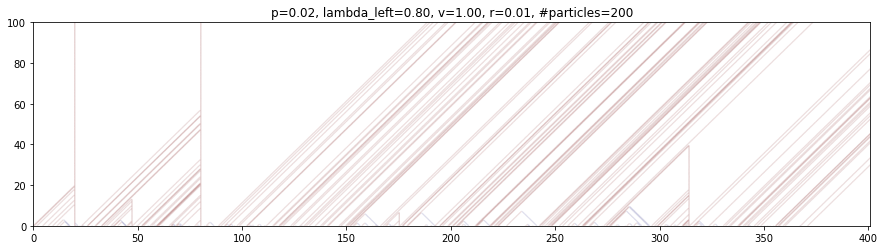

In [90]:
p0 = 1/50
q = 0.8
v = 1
r = 0.01
N = 200
eps = 0.1
time = 1000

z = BA_plot(p0, q, v, r, N, time, eps)